# Automated learning in Julia

In [1]:
using Distributions
using Random
using Flux
using OrdinaryDiffEq
using Plots 
using LaTeXStrings
using SciMLSensitivity
gr()

Plots.GRBackend()

## Ordinary differential equation 

In [2]:
# define true underlying ODE system
function linear_2d_system(du,u,p,t)
    a11, a12, a21, a22 = p
    z1,z2 = u
    du[1] = dz1 = a11 * z1 + a12 * z2
    du[2] = dz2 = a21 * z1 + a22 * z2
end
  
# define initial condition
true_u0 = Float32[2, 1]
# define time span on which to solve the ODE
tspan = (0.0f0, 10.0f0)
# define parameters for the two distinct groups
true_odeparams_group1 = Float32[-0.2, 0.00, 0.00, -0.2]
true_odeparams_group2 = Float32[-0.2, 0.00, 0.00, 0.2]
  
# define corresponding ODE problems for the two groups
prob1 = ODEProblem(linear_2d_system,true_u0,tspan,true_odeparams_group1)
prob2 = ODEProblem(linear_2d_system,true_u0,tspan,true_odeparams_group2)

ODEProblem with uType Vector{Float32} and tType Float32. In-place: true
timespan: (0.0f0, 10.0f0)
u0: 2-element Vector{Float32}:
 2.0
 1.0

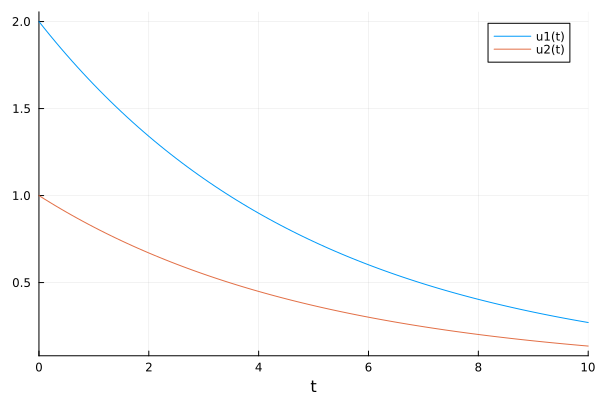

In [3]:
# solve ODE systems to obtain "true" underlying trajectory in each group
dt=0.1
sol_group1 = solve(prob1, Tsit5(), saveat = dt);
sol_group2 = solve(prob2, Tsit5(), saveat = dt);
plot(sol_group1)

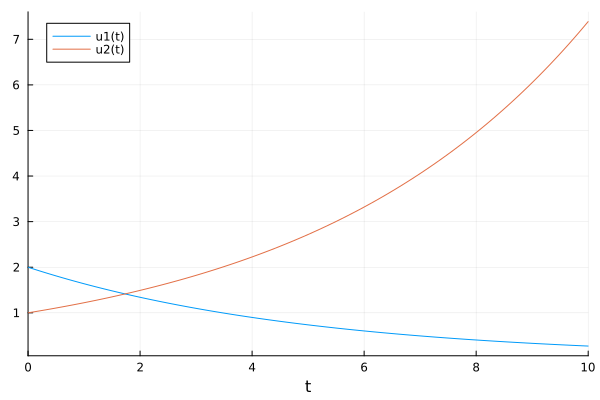

In [4]:
plot(sol_group2)

In [5]:
"""
    generate_xs(n, p, true_u0, sol_group1, sol_group2; t_start=1.5, t_end=10, maxntps = 10, dt=0.1, σ_var=0.1, σ_ind=0.5)

Generates simulated data by sampling `n` observations of `p` variables at between 1 and `maxntps` timepoints for each individual 
    by randomly selecting one of the true underlying ODE solutions given by `sol_group1` and `sol_group2`, taking its values 
    at a randomly sampled number between 1 and `maxntps` of randomly sampled time points and adding variable-specific 
    and individual-specific errors to the values of the true trajectories, where the variance of the error terms is controlled by 
    `σ_var` and `σ_ind`. 

Inputs: 
  - `n`: number of individuals to simulate 
  - `p`: number of time-dependent variables to simulate - should be divisible by the number of the true underlying 
        trajectory dimensions, so the first (p/n_true_dimensions) variables can be noisy versions of the first dimension of 
        the true dynamics, and so on. 
  - `true_u0`: vector stating the initial condition of the ground-truth underlying ODE systems from which to simulate the data 
  - `sol_group1`: true ODE solution of the first group 
  - `sol_group2`: true ODE solution of the second group 

Optional keyword arguments: 
 - `t_start`: Earliest time point possible for follow-up measurements, start of the interval from which to sample the 
        subsequent measurement time point(s). Default = 1.5
 - `t_end`: Latest time point possible for follow-up measurements, end of the interval from which to sample the 
        subsequent measurement time point(s). Default = 10
 - `maxntps`: maximum number of time points per individual after the baseline timepoint. Default = 1
 - `dt`: time steps at which to solve the ODE. Needed to ensure correct array sizes. Default = 0.1
 - `σ_var`: variance with which to sample the variable-specific error terms. Default = 0.1
 - `σ_ind`: variance with which to sample the individual-specific error terms. Default = 0.5

Returns:
 - `xs`: vector of length `n` = n_individuals, where the `i`th element is a (n_vars=p x n_timepoints) matrix 
        containing the simulated values of the time-dependent variables of the `i`th individual in the dataset
 - `tvals`: vector of length `n` = n_individuals, where the `i`th element is a vector of length 1 (or more generally n_timepoints_i)
        containing the simulated time point of the `i`th individual's second measurement (or all the timepoints after the baseline visit)
 - `group1`: indices of all individuals in group1 
 - `group2`: indices of all individuals in group1 
"""
function generate_xs(n, p, true_u0, sol_group1, sol_group2; t_start=1.5, t_end=10, maxntps = 10, dt=0.1, σ_var=0.1, σ_ind=0.5)

    # (1) generate artifical group labels
    groups = zeros(n)
    groups[randperm(n)[1:Int(floor(n/2))]] .= 1 # for groups of the same size
    group1 = findall(x -> x==1, groups)
    group2 = findall(x -> x==0, groups)

    # (2) generate artificial time stamps
    ntps = rand(1:maxntps, n)
    tvals = [sort(rand(t_start:dt:t_end,ntps[i])) for i in 1:n]

    # (3) obtain true values as solutions of the ODEs at the initial time point and the drawn second time point 
    # check for equal number of variables:
    if p%2 != 0
        error("Please select an even number of variables")
    end
    # true starting point    
    z_t0_p1 = true_u0[1] # for variables 1-(p/2)
    z_t0_p2 = true_u0[2] # for variables (p/2+1)-p
    z_t0 = repeat([z_t0_p1, z_t0_p2], inner=Int(p/2))

    # now use ODE solutions to obtain true temporal development value
    # for all individuals in both variables u1 and u2
    z_later_ts = collect((i ∈ group1) ? (Array(sol_group1)[:,Int.(round.(tvals[i].*(1 ./dt)).+1)]) : (Array(sol_group2)[:,Int.(round.(tvals[i].*(1 ./dt)).+1)]) for i in 1:n)

    # (4) sample variable- specific and individual-specific errors at both time points
    # variable specific random effect (general difficulty measuring that specific variable)
    us = rand(Normal(0,σ_var),p) 

    xs = []
    for i in 1:n 
        # make time series structure, should have shape (p x ntps[i])
        cur_timeseries = zeros(p, ntps[i]+1)
        for j in 1:p 
            cur_timeseries[j,1] = z_t0[j] + us[j] + randn() .* σ_ind
            for tp in 1:ntps[i]
                if j <= Int(p/2)
                    cur_timeseries[j,tp+1] = z_later_ts[i][1,tp] + us[j] + randn() .* σ_ind
                else
                    cur_timeseries[j,tp+1] = z_later_ts[i][2,tp] + us[j] + randn() .* σ_ind
                end
            end
        end
        push!(xs, cur_timeseries)
    end

    return xs, tvals, group1, group2
end

generate_xs

In [6]:
# define numbers of individuals and variables 
n = 100 
p = 10
q, q_info = 50, 10

# set seed for reproducibility
Random.seed!(12);

# generate time dependent variables
xs, tvals, group1, group2 = generate_xs(n, p, true_u0, sol_group1, sol_group2); 
# default vals: t_start=1.5, t_end=10, maxntps=10, dt=0.1, σ_var=0.1, σ_ind=0.5

In [7]:
"""
    generate_baseline(n, q, q_info, group1; σ_info=1, σ_noise=1)

Generates simulated baseline data by sampling `n` observations of `q` baseline variables, of which only the first `q_info`
    are informative, and the other ones are just pure noise variables, based on the group membership information. 
    This information is given by `group1`, the indices of all individuals in group1, based on which the other indices in 
    group 2 can be inferred, since union(group1, group2) = {1,...,n}. 
    Baseline measurements are simulated by encoding group membership as 1 or -1 and drawing from N(0,σ_info) or N(1, σ_info),
    repectively. For the noise variables, data are simulated by drawing from N(0, σ_noise). 

Inputs: 
 - `n`: number of individuals to simulate 
 - `q`: number of baseline variables to simulate 
 - `q_info`: number of informative baseline variables. 
 - `group1`: indices of all individuals in group1 - since [group1, group2] = {1,...,n}, the `group2` indices can be inferred from that

Optional keyword arguments: 
 - `σ_info`: variance with which to sample from the group membership information in the informative baseline variables terms. Default = 1
 - `σ_noise`: variance with which to sample the noise baseline variables terms. Default = 1

Returns:
 - `x_params`: vector of length `n` = n_individuals, where the `i`th  element is a vector of length (n_baselinevars=q)
        containing the baseline information for the `i`th individual in the dataset 
"""
function generate_baseline(n, q, q_info, group1; σ_info=1, σ_noise=1)
    zs = fill(1,(n,1))
    zs[group1].= -1
    means = fill(0,n,q)
    means[:,1:q_info] .= zs

    vars=fill(σ_noise,q)
    vars[1:q_info] .= σ_info
    x_params = [cat([rand(Normal(means[i,j],vars[j])) for j in 1:q]..., dims=1) for i in 1:n]
    return x_params
end

"""
    generate_baseline(n, q, q_info, group1, true_odeparams_group1, true_odeparams_group2; σ_info=0.1, σ_noise=0.1)

Generates simulated baseline data by sampling `n` observations of `q` baseline variables, of which only the first `q_info`
    are informative, and the other ones are just pure noise variables, based on the true ODE parameters passed as 
    `true_odeparams_group1` and `true_odeparams_group2`. 
    Baseline measurements are simulated by sampling from the true parameters with a standard deviation of σ_info. 
    For the noise variables, data are simulated by drawing from N(0, σ_noise). 

Inputs: 
 - `n`: number of individuals to simulate 
 - `q`: number of baseline variables to simulate 
 - `q_info`: number of informative baseline variables. 
 - `group1`: indices of all individuals in group1 - since [group1, group2] = {1,...,n}, the `group2` indices can be inferred from that

Optional keyword arguments: 
 - `σ_info`: variance with which to sample from the group membership information in the informative baseline variables terms. Default = 0.1. 
 - `σ_noise`: variance with which to sample the noise baseline variables terms. Default = 0.1. 

Returns:
 - `x_params`: vector of length `n` = n_individuals, where the `i`th  element is a vector of length (n_baselinevars=q)
        containing the baseline information for the `i`th individual in the dataset 
"""
function generate_baseline(n, q, q_info, group1, true_odeparams_group1, true_odeparams_group2; σ_info=0.1, σ_noise=0.1)
    signs = fill(1,(n,1))
    signs[group1] .= -1
    z1s = zeros(n,1)
    z1s[signs .== -1] .= true_odeparams_group1[1]
    z1s[signs .== 1] .= true_odeparams_group2[1]
    z2s = zeros(n,1)
    z2s[signs .== -1] .= true_odeparams_group1[4]
    z2s[signs .== 1] .= true_odeparams_group2[4]

    means = zeros(n,q)
    means[:,1:Int(floor(q_info/2))] .= z1s
    means[:,Int(floor(q_info/2))+1:q_info] .=z2s

    vars=fill(σ_noise,q)
    vars[1:q_info] .= σ_info
    x_params = [cat([rand(Normal(means[i,j],vars[j])) for j in 1:q]..., dims=1) for i in 1:n]
    return x_params
end

generate_baseline

In [8]:
# choose simulation setting for baseline variables 
baseline_simulation = "trueparams" # alternative: "groupsonly"

# generate baseline variables
if baseline_simulation == "trueparams"
    x_baseline = generate_baseline(n, q, q_info, group1, 
                                    true_odeparams_group1, true_odeparams_group2, 
                                    σ_info=0.1, σ_noise=0.1); 
    # defaul vals: σ_info=0.1, σ_noise=0.1
elseif baseline_simulation == "groupsonly"
    x_baseline = generate_baseline(n, q, q_info, group1, σ_info=1, σ_noise=1); 
    # default vals: σ_info=1, σ_noise=1
else
    error("Please select either 'trueparams' or 'groupsonly' as mode for simulation of baseline variables")
end
@info "simulation done!"

┌ Info: simulation done!
└ @ Main In[8]:16


In [9]:
#------------------------------
# some plotting functions for simulated data
#------------------------------

struct simdata
    xs
    x_baseline
    tvals
    group1
    group2
end

"""
    plot_truesolution(group, data::simdata, sol_group1, sol_group2; showdata=true)

Plots the true dynamics of one group according to the underlying ODE solution and the simulated data points on top. 

Inputs: 
 - `group`: integer specifying which group (1 or 2) to plot 
 - `data`: container of type `simdata` with all the simulated data (time-dependent and baseline variables, time points)
 - `sol_group1`: true ODE solution of the first group 
 - `sol_group2`: true ODE solution of the second group 

Returns: 
    a plot showing the true underlying ODE solutions as curves and the simulated time-dependent observations 
    as points on top. The two underlying dimensions of the ODE / the corresponding simulated variables 
    are color-coded in orange and blue. 
"""
function plot_truesolution(group, data::simdata, sol_group1, sol_group2; showdata=true)
    if group == 1
        sol = sol_group1
        groupinds = data.group1
        legendposition = :topright
    else
        sol = sol_group2
        groupinds = data.group2
        legendposition = :topleft
    end
    curplot = plot(sol.t, sol',
                label = [L"\mathrm{true~solution~}u_1" L"\mathrm{true~solution~}u_2"],
                legend = legendposition,
                legendfontsize = 12,
                line=(3, ["#ff7f0e" "#1f77b4"])
                )
    if !showdata
        return curplot
    else
        for ind in 1:length(data.xs[groupinds])
            for var in 1:size(data.xs[groupinds][1],1)
                color = "#ffbb78" 
                if var > 5
                    color = "#aec7e8"
                end
                Plots.scatter!(cat(0,data.tvals[groupinds][ind], dims=1), data.xs[groupinds][ind][var,:], label="", marker=(:c,6,color))
            end
        end
    end
    return curplot
end

plot_truesolution

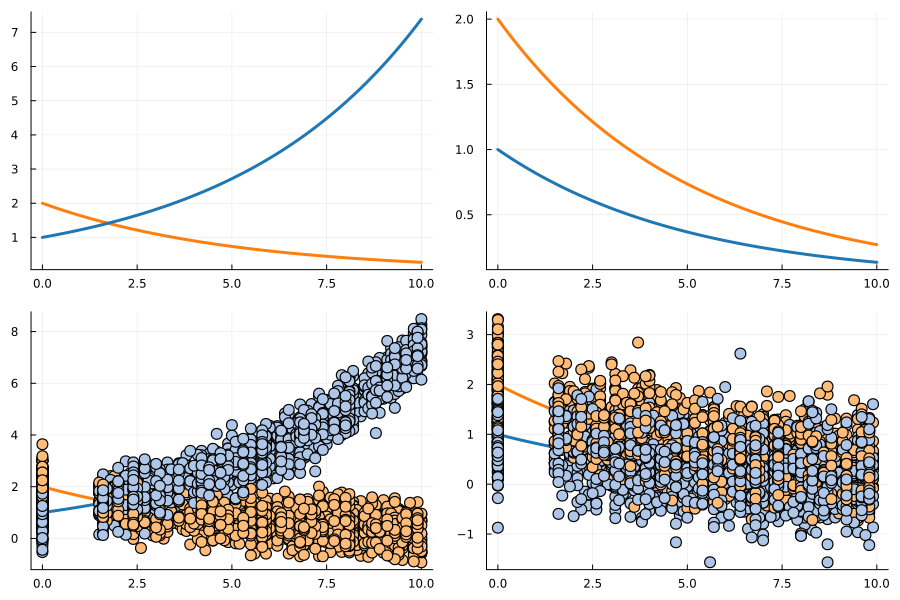

In [10]:
# look at data: 
data = simdata(xs, x_baseline, tvals, group1, group2);

plot(plot_truesolution(2, data, sol_group1, sol_group2, showdata=false), 
    plot_truesolution(1,  data, sol_group1, sol_group2, showdata=false), 
    plot_truesolution(2, data, sol_group1, sol_group2, showdata=true), 
    plot_truesolution(1,  data, sol_group1, sol_group2, showdata=true),
    layout = (2,2),
    legend = false,
    size = (900,600)
)

## Standard variational autoencoder 

In [11]:
mutable struct VAE 
    encoder
    encodedμ 
    encodedlogσ 
    decoder
    decodedμ 
    decodedlogσ 
end

function VAE(p::Int, zdim::Int; seed::Int=1234)
    Random.seed!(seed) # random weight initialisation - set seed for reproducibility
    #   VAE encoder
    Dz, Dh = zdim, p
    encoder, encodedμ, encodedlogσ = Dense(p, Dh, arg ->(tanh.(arg) .+ 1)), Dense(Dh, Dz), Chain(Dense(Dh, Dz, arg -> -relu(arg)), Flux.Diagonal(Dz))
    # VAE decoder
    decoder, decodedμ, decodedlogσ = Dense(Dz, Dh, tanh), Dense(Dh, p), Dense(Dh, p)
    return VAE(encoder, encodedμ, encodedlogσ, decoder, decodedμ, decodedlogσ)
end

VAE

In [12]:
latentz(μ, logσ) = μ .+ sqrt.(exp.(logσ)) .* randn(Float32,size(μ)...) # sample latent z,

kl_q_p(μ, logσ) = 0.5 .* sum(exp.(logσ) + μ.^2 .- 1 .- (logσ),dims=1)

logp_x_z(m, x, z) = sum(logpdf.(Normal.(m.decodedμ(m.decoder(z)), sqrt.(exp.(m.decodedlogσ(m.decoder(z))))), x),dims=1) # get reconstruction error

sqnorm(x) = sum(abs2, x)

reg(m) = sum(sqnorm, Flux.params(m.decoder,m.decodedμ,m.decodedlogσ)) # regularisation term in loss

getparams(m::VAE) = Flux.params(m.encoder, m.encodedμ, m.encodedlogσ, m.decoder, m.decodedμ, m.decodedlogσ) # get parameters of VAE model

function loss(m::VAE, X)
    latentμ, latentlogσ = m.encodedμ(m.encoder(X)), m.encodedlogσ(m.encoder(X))
    Z = latentz.(latentμ, latentlogσ)
    ELBO = 1.0 .* logp_x_z(m, X, Z) .- 0.5 .* kl_q_p(latentμ, latentlogσ)
    lossval = sum(-ELBO) + 0.01*reg(m) 
    return lossval
end

loss (generic function with 1 method)

In [13]:
function eval_zs(xs, group1, sol_group1, sol_group2, m, dt; swapcolorcoding::Bool=false) # look at trajectories of 4 exemplary individuals during training
    plotarray=[]
    for ind in 2:5
        curgroup = ind ∈ group1 ? 1 : 2
        colors_truesol = swapcolorcoding ? ["#ff7f0e" "#1f77b4"] : ["#1f77b4" "#ff7f0e"]
        curxs = xs[ind]
        curmu, cursi = m.encodedμ(m.encoder(curxs)), m.encodedlogσ(m.encoder(curxs))
        curz = latentz.(curmu, cursi)
        curts = tvals[ind] .* (1 ./dt) .+ 1
        #origt1s = repeat([tvals[ind]], length(curxs[:,1]))
        #origxst0 = curxs[:,1]
        #origxsotherts = curxs[:,2:end]
        curplot = curgroup == 1 ? plot(sol_group1.t, sol_group1'; legend=false, line=([:dot :dot], 3, colors_truesol)) : plot(sol_group2.t, sol_group2'; legend=false, line=([:dot :dot], 3, colors_truesol))
        Plots.scatter!(cat(0,tvals[ind], dims=1), curmu[1,:], marker = (:c, 4, "#1f77b4")) 
        Plots.scatter!(cat(0,tvals[ind], dims=1), curmu[2,:], marker = (:c, 4, "#ff7f0e"))
        # Plots.scatter!(zeros(10,1), origxst0; marker=(:c, 3, "#bab0ac"), alpha=0.5)
        #for tp in 1:length(tvals[ind])
        #    Plots.scatter!(repeat([tvals[ind][tp]], length(curxs[:,1])), origxsotherts[:,tp]; marker=(:c, 3, "#bab0ac"), alpha=0.5)
        #end
        push!(plotarray, curplot)
    end
    myplot = plot(plotarray[:]..., layout=(2,2))
    return myplot
end

eval_zs (generic function with 1 method)

In [14]:
zdim = 2
m = VAE(p, zdim, seed=678)

VAE(Dense(10 => 10, #22), Dense(10 => 2), Chain(Dense(10 => 2, #23), Scale(2)), Dense(2 => 10, tanh), Dense(10 => 10), Dense(10 => 10))

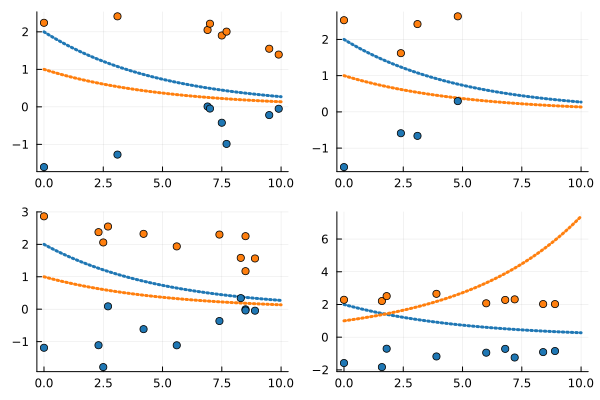

┌ Info: mean loss: 297.47588672981266
└ @ Main In[15]:2


In [15]:
display(eval_zs(xs, group1, sol_group1, sol_group2, m, dt))
@info "mean loss: $(mean(loss(m, X) for X in xs))"

In [16]:
ps = getparams(m)
opt = ADAM(0.0005)

Adam(0.0005, (0.9, 0.999), 1.0e-8, IdDict{Any, Any}())

┌ Info: mean loss: 118.25306836460875
└ @ Main In[17]:7


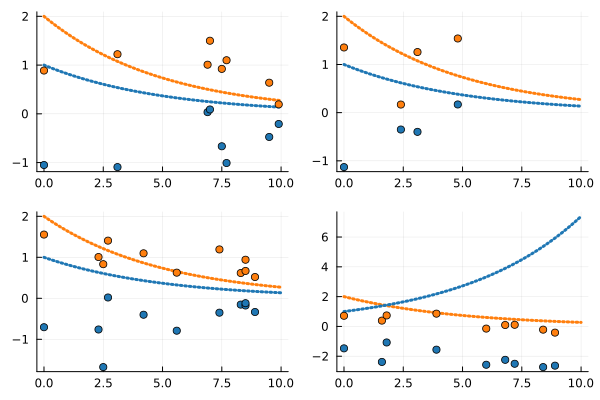

┌ Info: mean loss: 99.20771877638725
└ @ Main In[17]:7


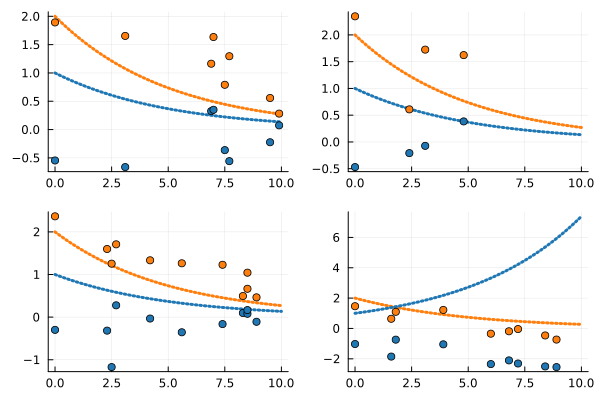

┌ Info: mean loss: 89.41552941375025
└ @ Main In[17]:7


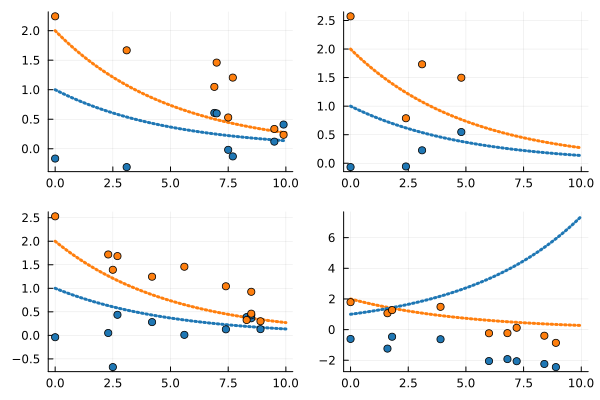

┌ Info: mean loss: 83.66954186502261
└ @ Main In[17]:7


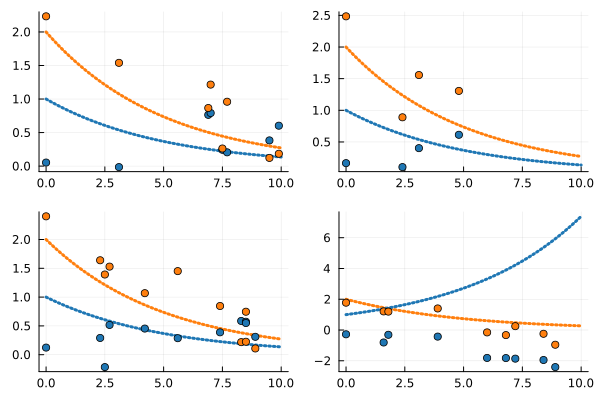

┌ Info: mean loss: 78.83274637037793
└ @ Main In[17]:7


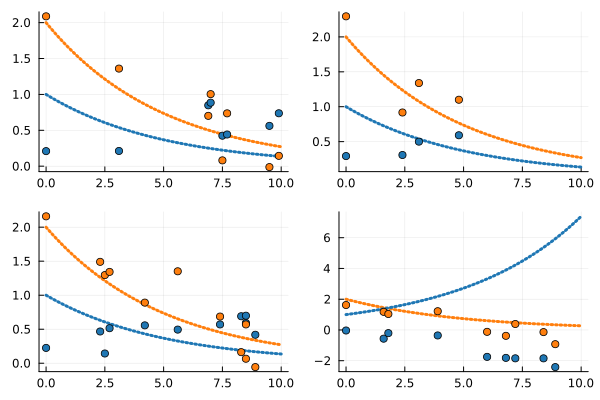

In [17]:
for epoch in 1:25
    for X in xs 
        grads = Flux.gradient(()-> loss(m, X), ps)
        Flux.Optimise.update!(opt, ps, grads)
    end
    if epoch % 5 == 0
        @info "mean loss: $(mean(loss(m, X) for X in xs))"
        display(eval_zs(xs, group1, sol_group1, sol_group2, m, dt; swapcolorcoding=true))
    end
end

## ODE Adapted VAE 

In [18]:
mutable struct ODE_VAE 
    encoder
    encodedμ 
    encodedlogσ 
    decoder
    decodedμ 
    decodedlogσ 
    paramNN
    ODEprob
end

# initialize model
function ODE_VAE(p::Int, q::Int, zdim::Int, nODEparams::Int, ODEprob; seed::Int=1234)
    myinit = Flux.glorot_uniform
    shift(arg) = sigmoid(arg).-0.5
    # seed
    Random.seed!(seed)
    # parameter network
    paramNN = Chain(Dense(q,q,tanh, init=myinit), 
                Dense(q, nODEparams, arg ->(shift(arg)), init=myinit), 
                Flux.Diagonal(nODEparams))
    #   VAE encoder
    Dz, Dh = zdim, p
    encoder, encodedμ, encodedlogσ = Dense(p, Dh, arg ->(tanh.(arg) .+ 1)), Dense(Dh, Dz), Chain(Dense(Dh, Dz, arg -> -relu(arg)), Flux.Diagonal(Dz))
    # VAE decoder
    decoder, decodedμ, decodedlogσ = Dense(Dz, Dh, tanh), Dense(Dh, p), Dense(Dh, p)
    return ODE_VAE(encoder, encodedμ, encodedlogσ, decoder, decodedμ, decodedlogσ, paramNN, ODEprob)
end

ODE_VAE

In [19]:
function loss(m::ODE_VAE, X, Y, t)
    latentμ, latentlogσ = m.encodedμ(m.encoder(X)), m.encodedlogσ(m.encoder(X))
    learnedparams = m.paramNN(Y)
    curparams = [learnedparams[1], m.ODEprob.p[2], m.ODEprob.p[3], learnedparams[2]]
    curts = Int.(floor.(t .*(1 ./dt) .+1))
    smoothμ = Array(solve(m.ODEprob, Tsit5(), u0 = [latentμ[1,1], latentμ[2,1]], p=curparams, saveat=dt))[:,curts]
    combinedμ = hcat(latentμ[:,1],smoothμ)
    combinedz = latentz.(combinedμ, latentlogσ)
    ELBO = 1.0 .* logp_x_z(m, X, combinedz) .- 0.5 .* kl_q_p(combinedμ, latentlogσ)
    lossval = sum(-ELBO) + 0.01*reg(m) + 1.0*sum((smoothμ .- latentμ[:,2:end]).^2)
    return lossval
end

getparams(m::ODE_VAE) = Flux.params(m.encoder, m.encodedμ, m.encodedlogσ, m.decoder, m.decodedμ, m.decodedlogσ, m.paramNN) # get parameters of VAE model

getparams (generic function with 2 methods)

In [20]:
"""
    eval_z_trajectories(xs, x_params,tvals, group1, sol_group1, sol_group2, m, dt; swapcolorcoding::Bool=false)

Callback function to be used during training: Plot the fitted latent space ODE solutions and the encoder values before solving the ODE
    for some exemplary individuals in the dataset, together with the ground truth underlying ODE trajectories.  

Inputs:
 - `xs`: vector of length `n` = n_individuals, where the `i`th element is a (n_vars=p x n_timepoints) matrix 
        containing the time-dependent variables of the `i`th individual in the dataset
 - `x_params`: vector of length `n` = n_individuals, where the `i`th  element is a vector of length (n_baselinevars=q)
        containing the baseline information for the `i`th individual in the dataset 
 - `tvals`: vector of length `n` = n_individuals, where the `i`th element is a vector of length 1 (or more generally n_timepoints_i)
        containing the time point of the `i`th individual's second measurement (or all the timepoints after the baseline visit)
 - `group1`: indices of all individuals in group1 - since [group1, group2] = {1,...,n}, the `group2` indices can be inferred from that 
 - `sol_group1`: true ODE solution of the first group 
 - `sol_group2`: true ODE solution of the second group 
 - `m`: ODE-VAE model of which the latent space should be exemplarily visualized 
 - `dt`: time interval in which to use the ODE, needed to ensure correct array dimensions for plotting 
 - `swapcolorcoding`: optional keyword argument whether or not to swap the orange - blue color coding for the true underlying trajectories, 
        as the VAE can arbitrarily flip / rotate the latent representation, sometimes resulting in inverted dimensions, 
        which can be visually remedied by swapping the color coding there. Default = `false`. 

Returns: 
    A plot with 4 panels representing the latent space of one individual each. The true underlying ODE solutions are shown as dashed curves
    and the fitted ones obtained from solving the individually parameterized ODE in the latent space are shown as solid curves. 
    The two latent space dimensions are color-coded in orange and blue. 
"""
function eval_z_trajectories(xs, x_params,tvals, group1, sol_group1, sol_group2, m, dt; swapcolorcoding::Bool=false) # look at trajectories of first 4 individuals during training
    plotarray=[]
    for ind in 2:5
        curgroup = ind ∈ group1 ? 1 : 2
        colors_truesol = swapcolorcoding ? ["#ff7f0e" "#1f77b4"] : ["#1f77b4" "#ff7f0e"]
        curxs = xs[ind]
        curmu, cursi = m.encodedμ(m.encoder(curxs)), m.encodedlogσ(m.encoder(curxs))
        curz = latentz.(curmu, cursi)
        learnedparams = m.paramNN(x_params[ind])
        if length(m.paramNN.layers[end].scale) == 2
            curparams = Float32[learnedparams[1], m.ODEprob.p[2], m.ODEprob.p[3], learnedparams[2]]
        else
            curparams = learnedparams
        end    
        curts = tvals[ind] .* (1 ./dt) .+ 1
        origt1s = repeat([tvals[ind]], length(curxs[:,1]))
        cursol = solve(m.ODEprob, Tsit5(), u0 = curmu[:,1], p=curparams, saveat = dt)
        curplot = curgroup == 1 ? plot(sol_group1.t, sol_group1'; legend=false, line=([:dot :dot], 3, colors_truesol)) : plot(sol_group2.t, sol_group2'; legend=false, line=([:dot :dot], 3, colors_truesol))
        plot!(cursol.t, cursol'; line=(2, ["#1f77b4" "#ff7f0e"]))
        Plots.scatter!(cat(0,tvals[ind], dims=1), curmu[1,:], marker = (:c, 4, "#1f77b4")) 
        Plots.scatter!(cat(0,tvals[ind], dims=1), curmu[2,:], marker = (:c, 4, "#ff7f0e"))
        push!(plotarray, curplot)
    end
    myplot = plot(plotarray[:]..., layout=(2,2))
    return myplot
end

eval_z_trajectories

In [21]:
zdim = nODEparams = 2
m = ODE_VAE(p, q, zdim, nODEparams, prob1, seed=42);

┌ Info: mean loss: 264.20120033901367
└ @ Main In[22]:2


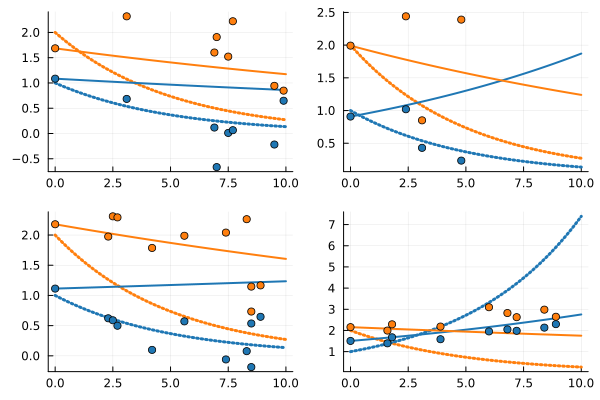

In [22]:
trainingdata = zip(xs, x_baseline, tvals)
@info "mean loss: $(mean(loss(m, d...) for d in trainingdata))"
display(eval_z_trajectories(xs, x_baseline, tvals, group1, sol_group1, sol_group2, m, dt, swapcolorcoding=true))

┌ Info: mean loss: 129.90753104991768
└ @ Main In[23]:10


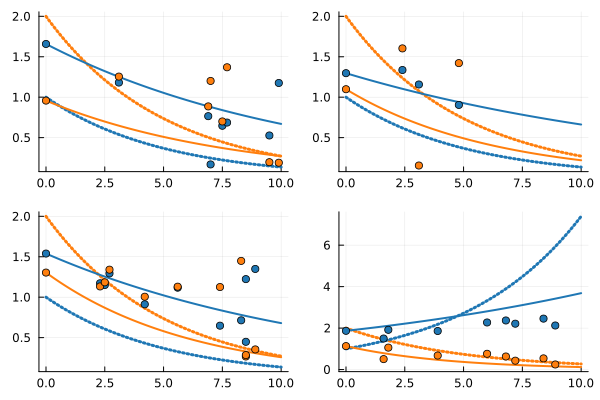

┌ Info: mean loss: 105.22542947804983
└ @ Main In[23]:10


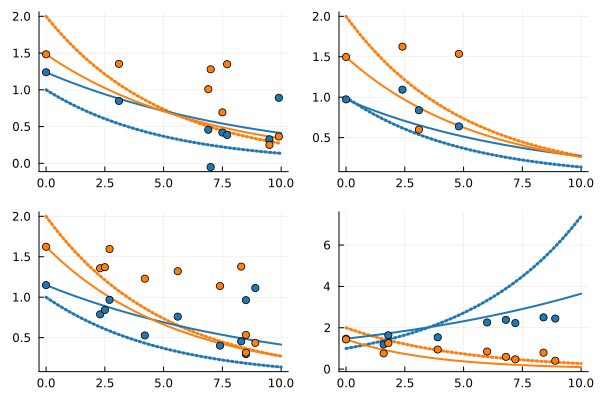

┌ Info: mean loss: 92.86396138961818
└ @ Main In[23]:10


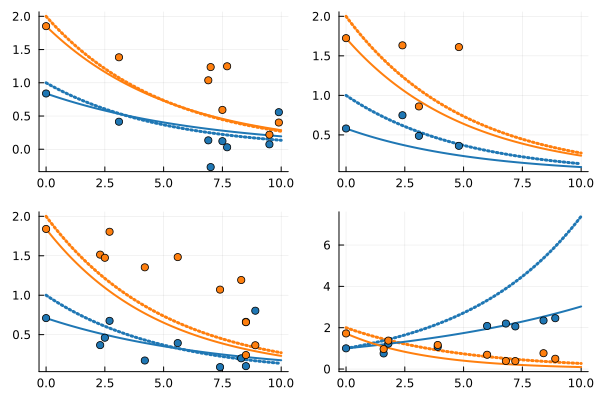

┌ Info: mean loss: 86.23264116280163
└ @ Main In[23]:10


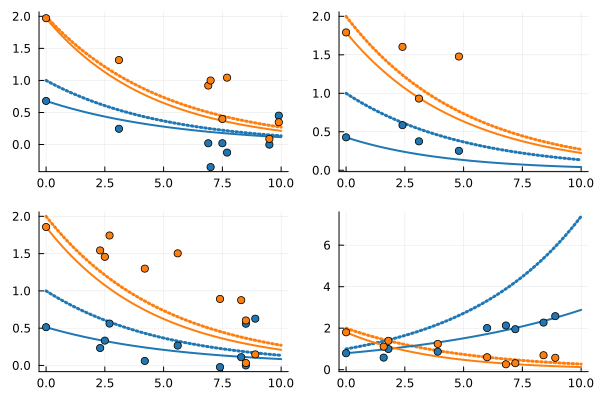

┌ Info: mean loss: 82.01036018092191
└ @ Main In[23]:10


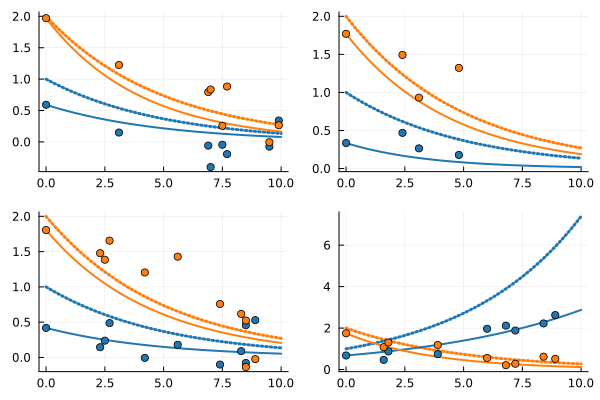

In [23]:
ps = getparams(m)
opt = ADAM(0.0005)

for epoch in 1:25
    for d in trainingdata 
        grads = Flux.gradient(()-> loss(m, d...), ps)
        Flux.Optimise.update!(opt, ps, grads)
    end
    if epoch % 5 == 0
        @info "mean loss: $(mean(loss(m, d...) for d in trainingdata))"
        display(eval_z_trajectories(xs, x_baseline, tvals, group1, sol_group1, sol_group2, m, dt, swapcolorcoding=true))
    end
end

In [24]:
"""
    plot_individual_solutions(ind, xs, x_baseline, tvals, group1, sol_group1, sol_group2, m, dt; swapcolorcoding::Bool=false, showlegend::Bool=true)

Plot the fitted ODE solutions in the latent space of the ODE-VAE `m` and the encoded datapoints before solving the ODE together with 
    the ground-truth underlying ODE trajectory for one individual, defined by its index `ind`.

Inputs: 
 - `ind`: the index of the individual in the dataset, between 1 and `n` = n_individuals
 - `xs`: vector of length `n` = n_individuals, where the `i`th element is a (n_vars=p x n_timepoints) matrix 
        containing the time-dependent variables of the `i`th individual in the dataset
 - `x_baseline`: vector of length `n` = n_individuals, where the `i`th  element is a vector of length (n_baselinevars=q)
        containing the baseline information for the `i`th individual in the dataset 
 - `tvals`: vector of length `n` = n_individuals, where the `i`th element is a vector of length 1 (or more generally n_timepoints_i)
        containing the time point of the `i`th individual's second measurement (or all the timepoints after the baseline visit)
 - `group1`: indices of all individuals in group1 - since [group1, group2] = {1,...,n}, the `group2` indices can be inferred from that 
 - `sol_group1`: true ODE solution of the first group 
 - `sol_group2`: true ODE solution of the second group 
 - `m`: ODE-VAE model of which the latent space should be exemplarily visualized 
 - `dt`: time interval in which to use the ODE, needed to ensure correct array dimensions for plotting 
 - `swapcolorcoding`: optional keyword argument whether or not to swap the orange - blue color coding for the true underlying trajectories, 
        as the VAE can arbitrarily flip / rotate the latent representation, sometimes resulting in inverted dimensions, 
        which can be visually remedied by swapping the color coding there. Default = `false`
 - `showlegend`: optional keyword argument whether or not to display the plot legend. Default = `true`

Returns: 
    A plot representing the latent space of one individual. The true underlying ODE solutions are shown as dashed curves
    and the fitted one by solving the individually parameterized ODE in the latent space are shown as solid curves, 
    the encoded datapoints are scattered on top. The two latent space dimensions are color-coded in orange and blue. 
"""
function plot_individual_solutions(ind, xs, x_baseline, tvals, group1, sol_group1, sol_group2, m, dt; swapcolorcoding::Bool=false, showlegend::Bool=true) # look at trajectories of one individual after training 
    curgroup = ind ∈ group1 ? 1 : 2
    colors_truesol = swapcolorcoding ? ["#ff7f0e" "#1f77b4"] : ["#1f77b4" "#ff7f0e"]
    if curgroup == 1
        sol = sol_group1
        legend = showlegend ? :topright : false
        truesollabels = ""
        smoothlabels = ""
        label1 = ""
        label2 = ""
    else
        sol = sol_group2
        legend = showlegend ? :topleft : false
        truesollabels = [L"\mathrm{true~}u_1" L"\mathrm{true~}u_2"]
        smoothlabels = [L"\mathrm{smooth~}\mu_1" L"\mathrm{smooth~}\mu_2"]
        label1 = L"\mu_1 \mathrm{~from~encoder}"
        label2 = L"\mu_2 \mathrm{~from~encoder}"
    end
    curxs = xs[ind]
    curmu, cursi = m.encodedμ(m.encoder(curxs)), m.encodedlogσ(m.encoder(curxs))
    learnedparams = m.paramNN(x_baseline[ind])
    if length(m.paramNN.layers[end].scale) == 2
        curparams = Float32[learnedparams[1], m.ODEprob.p[2], m.ODEprob.p[3], learnedparams[2]]
    else
        curparams = learnedparams
    end    
    cursol = solve(m.ODEprob, Tsit5(), u0 = curmu[:,1], p=curparams, saveat = dt)
    curplot = plot(sol.t, sol'; labels=truesollabels, legend=legend, line=([:dot :dot], 3, colors_truesol))
    plot!(cursol.t, cursol'; labels=smoothlabels, line=(2, ["#1f77b4" "#ff7f0e"]))
    Plots.scatter!(cat(0,tvals[ind], dims=1), curmu[1,:], label = label1, marker = (:c, 6, "#1f77b4")) 
    Plots.scatter!(cat(0,tvals[ind], dims=1), curmu[2,:], label = label2, marker = (:c, 6, "#ff7f0e"))
    plot!(xlab="time", ylab="value of latent representation")
    #display(curplot)

    return curplot

end

"""
    allindsplot(group, data::simdata, m, sol_group1, sol_group2; swapcolorcoding::Bool=false, showlegend::Bool=true)

Shows the fitted latent space ODE solutions and the encoded data points from all individuals in one group in one plot, 
    together with the true underlying ODE trajectory as dashed line. 

Inputs: 
 - `group`: integer specifying which group (1 or 2) to plot 
 - `data`: container of type `simdata` with all the simulated data (time-dependent and baseline variables, time points)
 - `m`: trained ODE-VAE model 
 - `sol_group1`: true ODE solution of the first group 
 - `sol_group2`: true ODE solution of the second group 
 - `swapcolorcoding`: optional keyword argument whether or not to swap the orange - blue color coding for the true underlying trajectories, 
        as the VAE can arbitrarily flip / rotate the latent representation, sometimes resulting in inverted dimensions, 
        which can be visually remedied by swapping the color coding there. Default = `false`
 - `showlegend`: optional keyword argument whether or not to display the plot legend. Default = `true`

Returns: 
    A plot showing all latent space ODE solutions and the encoded data points from all individuals in one group. 
    The true underlying ODE solutions are shown as dashed curves and the fitted one by solving the individually 
    parameterized ODE in the latent space are shown as solid curves, the encoded datapoints are scattered on top. 
    The two latent space dimensions are color-coded in orange and blue. 
"""
function allindsplot(group, data::simdata, m, sol_group1, sol_group2; swapcolorcoding::Bool=false, showlegend::Bool=true)
    # get data
    xs, x_params, tvals = data.xs, data.x_baseline, data.tvals
    # set parameters
    if group == 1
        sol = sol_group1
        groupinds = group1
        legendposition = showlegend ? :topright : false
        ylims = (-0.3,4.2)
    else
        sol = sol_group2
        groupinds = group2
        legendposition = showlegend ? :topleft : false
        ylims = (-0.5,12)
    end

    # plot true solution
    colors_truesol = swapcolorcoding ? ["#ff7f0e" "#1f77b4"] : ["#1f77b4" "#ff7f0e"]
    allindsplot1 = plot(sol.t, sol';
                    #ylims = ylims,
                    labels=[L"\mathrm{true~}u_1" L"\mathrm{true~}u_2"],
                    legend=legendposition,
                    line=([:dot :dot], 4, colors_truesol)#["#e6550d" "#3182bd"])
    )
    # get data from group currently looked at
    groupxs = xs[groupinds]
    groupx_params = x_params[groupinds]
    grouptvals = tvals[groupinds]
    # plot ODE solutions (= smooth latent μs as function of t)    
    for ind in 1:length(xs[groupinds])
        curxs = groupxs[ind]
        curmu, cursi = m.encodedμ(m.encoder(curxs)), m.encodedlogσ(m.encoder(curxs))
        learnedparams = m.paramNN(groupx_params[ind])
        if length(m.paramNN.layers[end].scale) == 2
            curparams = Float32[learnedparams[1], m.ODEprob.p[2], m.ODEprob.p[3], learnedparams[2]]
        else
            curparams = learnedparams
        end
        cursol = solve(m.ODEprob, Tsit5(), u0 = curmu[:,1], p=curparams, saveat = dt)
        if ind == 2
            labels = [L"\mathrm{smooth~}\mu_1" L"\mathrm{smooth~}\mu_2"]
            label1 = L"\mu_1 \mathrm{~from~encoder}"
            label2 = L"\mu_2 \mathrm{~from~encoder}"
        else
            labels = ""
            label1 = ""
            label2 = ""
        end
        plot!(cursol.t, cursol'; label=labels, line=(0.5, ["#3182bd" "#e6550d"])) #["#6baed6" "#fd8d3c"]
    end
    # plot latent μs obtained directly from the encoder before the ODE solving step
    for ind in 1:length(xs[groupinds])
        curxs = groupxs[ind]
        curmu, cursi = m.encodedμ(m.encoder(curxs)), m.encodedlogσ(m.encoder(curxs))
        if ind == 2
            labels = [L"\mathrm{smooth~}\mu_1" L"\mathrm{smooth~}\mu_2"]
            label1 = L"\mu_1 \mathrm{~from~encoder}"
            label2 = L"\mu_2 \mathrm{~from~encoder}"
        else
            labels = ""
            label1 = ""
            label2 = ""
        end
        Plots.scatter!(cat(0,grouptvals[ind], dims=1),curmu[1,:]; label=label1, marker=(:c,4,"#9ecae1"))
        Plots.scatter!(cat(0,grouptvals[ind], dims=1),curmu[2,:]; label=label2, marker=(:c,4,"#fdae6b"))
    end
    plot!(xlab="time", ylab="value of latent representation")

    return allindsplot1

end

allindsplot

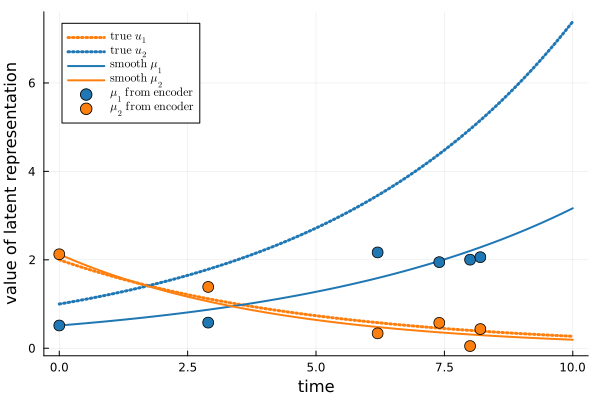

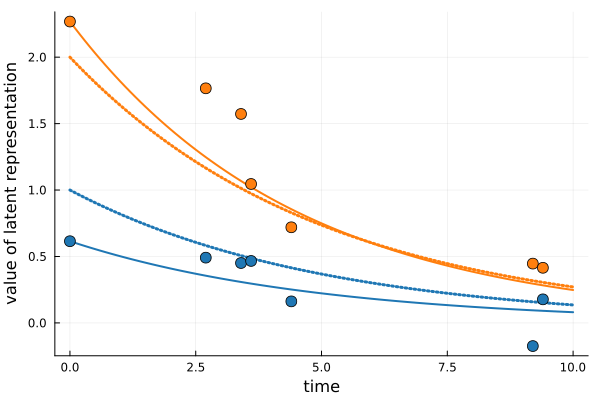

In [25]:
p1 = plot_individual_solutions(20,xs, x_baseline, tvals, group1, sol_group1, sol_group2, m, dt, 
                                swapcolorcoding=true, showlegend=true)
p2 = plot_individual_solutions(28,xs, x_baseline, tvals, group1, sol_group1, sol_group2, m, dt, 
                                swapcolorcoding=true, showlegend=false)
display(p1)
display(p2)

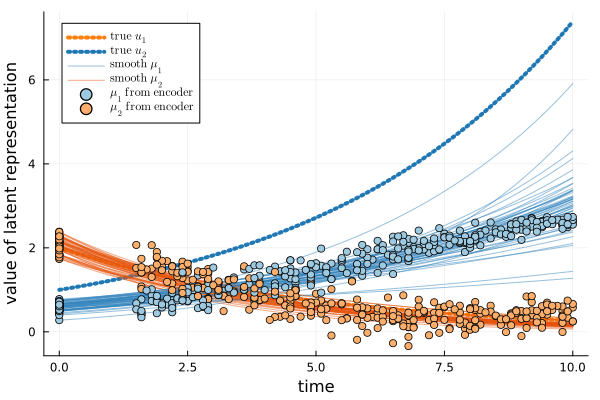

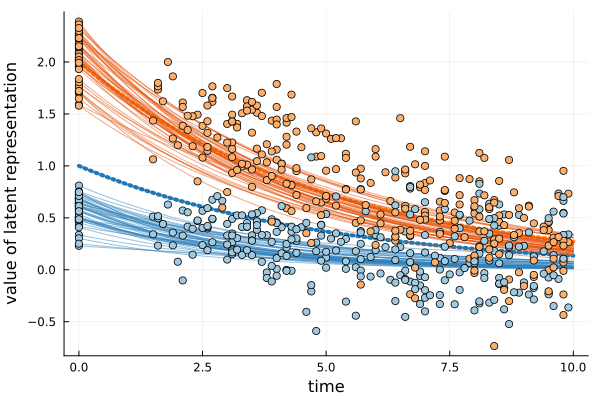

In [26]:
# solutions across the entire dataset
data = simdata(xs, x_baseline, tvals, group1, group2);

p3 = allindsplot(2, data, m, sol_group1, sol_group2, swapcolorcoding=true)
p4 = allindsplot(1, data, m, sol_group1, sol_group2, swapcolorcoding=true, showlegend=false)

display(p3)
display(p4)

## Neural Network

In [27]:
using Flux
using Random

dense_sol = solve(ODEProblem(linear_2d_system, u0, tspan, true_p), Tsit5(), saveat=0.01)
sol_mat = Array(dense_sol)
# split into two components 
# add some random noise
n=100 # dataset size
groups = rand([1,2], n)
dataset = Float32.(cat([sol_mat[i,:] .+ randn(size(sol_mat[i,:])) for i in groups]..., dims=2)')

randindex = shuffle(1:n)
train_inds = randindex[1:Int(floor(n*0.8))]
test_inds = randindex[Int(floor(n*0.8))+1:end]

train_data = dataset[train_inds,:]
test_data = dataset[test_inds,:]

labels = Float32.(groups) .- 1.0f0
train_labels = labels[train_inds]
test_labels = labels[test_inds]

Random.seed!(42)
inputdim = size(train_data,2)
classifier = Chain(
                Dense(inputdim, 10, relu),
                Dense(10, 1)
)

NNloss(m, x, y) = Flux.logitbinarycrossentropy(vec(m(x)), y)

# get the current loss and gradients wrt the model parameters 
ps = Flux.params(classifier)
NNloss(classifier, train_data', train_labels)
grads = Flux.gradient(() -> NNloss(classifier, train_data', train_labels), ps)
grads.grads
length(ps)

# train the model 
η = 0.001
nepochs=100
opt = ADAM(η)
trainingdata = Flux.DataLoader((train_data', train_labels), batchsize=10, shuffle=true)

trainlosses = []
testlosses = []

for epoch in 1:nepochs
    for batch in trainingdata
        grads = Flux.gradient(() -> NNloss(classifier, batch...), ps)
        Flux.Optimise.update!(opt, ps, grads)
    end
    push!(trainlosses, NNloss(classifier, train_data', train_labels))
    push!(testlosses, NNloss(classifier, test_data', test_labels))
    
    if epoch % 10 == 0 # show loss only at 20 timepoints
        @info "epoch $(epoch): current train loss: $(NNloss(classifier, train_data', train_labels)), current test loss: $(NNloss(classifier, test_data', test_labels))"
    end    
end

p1 = plot(collect(1:nepochs), hcat(log.(10, trainlosses .+ 1), log.(10, testlosses .+1 )), title = "Loss", label=["train-loss" "test-loss"], xlabel="number of epoch", ylabel="log10(model loss)", legend=:topright)

LoadError: UndefVarError: u0 not defined